In [1]:
# Название проекта
%%html
<div padding: 40px">
    
<div>
<h1>Анализ активности пользователей в чатах Пачки и Слак <a class="tocSkip"> </h1>

# Описание проекта

## Заказчик 
Яндекс практиткум

## Проблемма
Проблема – низкая обратная связь на важные посты, публикуемые в чатах.

## Цель исследования
Цель проекта - проанализировать активность в чатах Пачки и Слак. 
* Выявить паттерны, динамику, цикличность в течение дня, недели, месяца, года. Визуализировать свои находки. 
* Понять, когда активность студентов в чатах наибольшая, и когда лучше публиковать посты/анонсы, чтобы получить больше откликов.
* Проанализировать различные типы каналов, когорт, групп. оценить в каких общения больше, в каких меньше, и как они различаются от когорты к когорте, от канала к каналу

##  Описание данных
-	Unnamed: 0  -  Индекс
-	client_msg_id -  id сообщения 
-	type – тип поста 
-	user – id пользователя 
-	ts – дата поста
-	latest_reply – дата ответа
-	team -  факт вхождения в неизвестную группу. Возможно что то другое.
-	thread_ts – дата треда
-	subtype – метка действий пользователя
-	channel - канал
-	file_date – дата файла
-	attachments – прикрепленные файлы
-	reactions – реакции
-	text_len – длина текста сообщения
-	text_words – количество слов в сообщении



# Загрузка данных

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import datetime as dt
import time
import numpy as np
import warnings
import folium
import json
import geopandas as gpd
from folium import Choropleth
from folium import Map, Marker
from folium.plugins import MarkerCluster
import yaml
import ast
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

In [2]:
#унифицируем размер графиков
sns.set(rc={'figure.figsize':(10, 5)})
#настраиваем отображение колонок (полностью)
pd.set_option('display.max_columns', None)
#настраиваем отображение формата значений
pd.options.display.float_format = '{:,.2f}'.format
#вывод значений без сокращений
pd.set_option('display.max_colwidth', -1)
#убираем системные предупреждения
warnings.filterwarnings('ignore')

C:\Users\User\AppData\Local\Temp\ipykernel_18340\1713447748.py:8: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [3]:
#открываем и сохраняем как датафрейм файл с данными:
df = pd.read_csv('chat_data_clean.csv', parse_dates=['ts'])
df.head()

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,1669643363.454049,"1,669,645,448.32",TPV9DP0N4,"1,669,643,363.45",NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,1669645448.322809,NaN,TPV9DP0N4,"1,669,643,363.45",NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",434,63
2,2,NaN,message,U02KVQJHQ5S,1669646930.328279,NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5
3,3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,1669709292.155959,"1,669,719,417.16",NaN,"1,669,709,292.16",NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",69,12
4,4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,1669710752.082299,NaN,TPV9DP0N4,"1,669,709,292.16",NaN,data-analysts-bus,2022-11-29,0,NaN,19,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26533 entries, 0 to 26532
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26533 non-null  int64  
 1   client_msg_id  18262 non-null  object 
 2   type           26533 non-null  object 
 3   user           23643 non-null  object 
 4   ts             26533 non-null  object 
 5   latest_reply   2303 non-null   float64
 6   team           15857 non-null  object 
 7   thread_ts      18222 non-null  float64
 8   subtype        8317 non-null   object 
 9   channel        26533 non-null  object 
 10  file_date      26533 non-null  object 
 11  attachments    26533 non-null  int64  
 12  reactions      4169 non-null   object 
 13  text_len       26533 non-null  int64  
 14  text_words     26533 non-null  int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 3.0+ MB


In [5]:
# приводим типы данных к нужному формату
df['ts'] = pd.to_datetime(df['ts'], unit='s').dt.round('1s')
df['latest_reply'] = pd.to_datetime(df['latest_reply'], unit='s').dt.round('1s')
df['thread_ts'] = pd.to_datetime(df['thread_ts'], unit='s').dt.round('1s')
df['file_date'] = pd.to_datetime(df['file_date'])
df['attachments'] = df['attachments'].astype('bool')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,False,NaN,297,47
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,False,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",434,63
2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-28,False,NaN,37,5
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,False,"[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",69,12
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,False,NaN,19,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26533 entries, 0 to 26532
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   client_msg_id  18262 non-null  object        
 1   type           26533 non-null  object        
 2   user           23643 non-null  object        
 3   ts             26533 non-null  datetime64[ns]
 4   latest_reply   2303 non-null   datetime64[ns]
 5   team           15857 non-null  object        
 6   thread_ts      18222 non-null  datetime64[ns]
 7   subtype        8317 non-null   object        
 8   channel        26533 non-null  object        
 9   file_date      26533 non-null  datetime64[ns]
 10  attachments    26533 non-null  bool          
 11  reactions      4169 non-null   object        
 12  text_len       26533 non-null  int64         
 13  text_words     26533 non-null  int64         
dtypes: bool(1), datetime64[ns](4), int64(2), object(7)
memory usage: 2.7+ 

In [7]:
# Изучаем процент пропущенных значений
pd.DataFrame(df.isna().mean()*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
latest_reply,91.320243
reactions,84.287491
subtype,68.654129
team,40.236686
thread_ts,31.323258
client_msg_id,31.172502
user,10.892097
text_words,0.000000
text_len,0.000000
attachments,0.000000


<h4>Вывод: <a class="tocSkip"> </h4>  
    Итого, в таблице 26533 записей, и 14 столбцов. 7 столбцов - текстовые, 4 - с датами и временем, 2-целочисленные, 1 - булевый. 7 столбцов не имеют пропусков. Остальные семь имеют пропуски от 10% до 91%. Больше всего пропусков в столбцах с реакциями и временем ответа 84 и 91 процент. 

# Предобработка данных

Начнем со столбцов не имеющих пропусков

## text_len (Длина текста сообщения)

          кол-во сообщений
text_len                  
35        3401            
37        2104            
74        211             
0         211             
10        177             
...       ...             
1021      1               
1016      1               
1010      1               
1009      1               
10933     1               

[1173 rows x 1 columns]


count   26,533.00
mean    155.16   
std     242.82   
min     0.00     
25%     37.00    
50%     80.00    
75%     178.00   
max     10,933.00
Name: text_len, dtype: float64

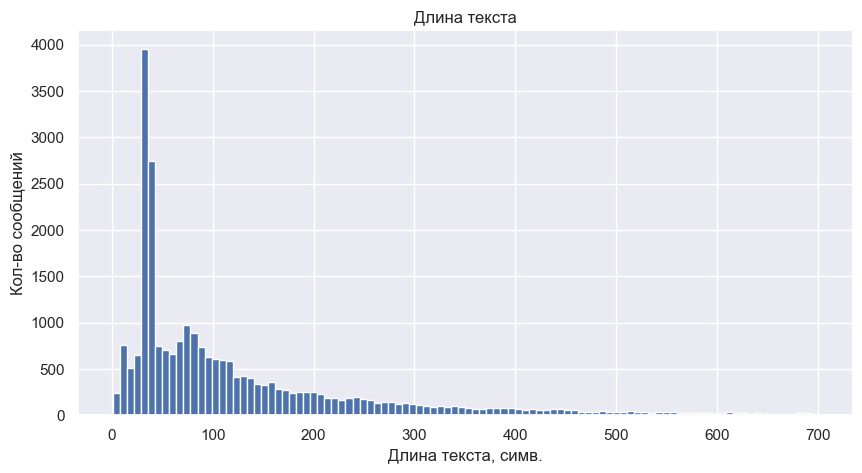

In [8]:
# Построим гимтограмму и сводную таблицу
df.hist('text_len', bins=100, range=(1,700))
plt.title('Длина текста')
plt.xlabel('Длина текста, симв.')
plt.ylabel('Кол-во сообщений')
print(df.pivot_table(index= 'text_len', values= 'type', aggfunc= 'count').sort_values(by = 'type', ascending=False).rename(columns= {'type': 'кол-во сообщений'}))
df['text_len'].describe()

In [9]:
# имеем 211 сообщений с длиной текста - 0. посмотрим на них
df.query('text_len == 0').head()

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
125,380292ed-96eb-4a36-ae8e-3a2ca9fde9a8,message,U02ML32S2DT,2022-12-10 13:41:20,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-10,False,NaN,0,0
132,e0e727a3-fc59-42e4-a3dd-ee1830ed3d39,message,U01QA2MU76E,2022-12-10 15:04:41,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-10,False,NaN,0,0
143,8972121e-e4eb-4a0d-bac7-b58312094098,message,U02ML32S2DT,2022-12-14 11:41:20,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-14,False,NaN,0,0
144,df26d4f3-fbcb-45c7-a6a1-86bcab0dc206,message,U02ML32S2DT,2022-12-14 11:41:37,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-14,False,NaN,0,0
149,6726ab42-5207-4246-ae78-d449a1e71708,message,U02ML32S2DT,2022-12-14 12:05:30,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-14,False,NaN,0,0


Расперделение данных выглядит нормально, за исключением нулевых значений. Их скорее всего нужно будет удалить. Наибольшее кол-во сообщений с длиной 35 символов. Медианное кол-во символов в выборке 80. 

## text_words (количество слов в сообщении)
Сделаем аналогично как в предыдущем пункте

            кол-во сообщений
text_words                  
5           5989            
2           944             
12          846             
13          823             
14          781             
...         ...             
141         1               
226         1               
225         1               
222         1               
989         1               

[280 rows x 1 columns]


count   26,533.00
mean    20.74    
std     30.82    
min     0.00     
25%     5.00     
50%     11.00    
75%     24.00    
max     989.00   
Name: text_words, dtype: float64

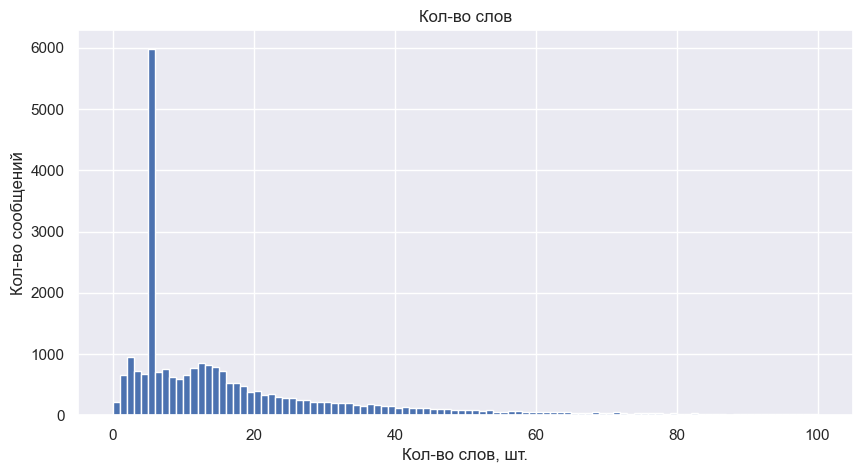

In [10]:
# Построим гимтограмму и сводную таблицу
df.hist('text_words', bins=100, range=(0,100))
plt.title('Кол-во слов')
plt.xlabel('Кол-во слов, шт.')
plt.ylabel('Кол-во сообщений')
print(df.pivot_table(index= 'text_words', values= 'type', aggfunc= 'count').sort_values(by = 'type', ascending=False).rename(columns= {'type': 'кол-во сообщений'}))
df['text_words'].describe()

In [11]:
# имеем 211 сообщений с кол-вом слов - 0. посмотрим на них
df.query('text_words == 0')

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
125,380292ed-96eb-4a36-ae8e-3a2ca9fde9a8,message,U02ML32S2DT,2022-12-10 13:41:20,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-10,False,NaN,0,0
132,e0e727a3-fc59-42e4-a3dd-ee1830ed3d39,message,U01QA2MU76E,2022-12-10 15:04:41,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-10,False,NaN,0,0
143,8972121e-e4eb-4a0d-bac7-b58312094098,message,U02ML32S2DT,2022-12-14 11:41:20,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-14,False,NaN,0,0
144,df26d4f3-fbcb-45c7-a6a1-86bcab0dc206,message,U02ML32S2DT,2022-12-14 11:41:37,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-14,False,NaN,0,0
149,6726ab42-5207-4246-ae78-d449a1e71708,message,U02ML32S2DT,2022-12-14 12:05:30,NaT,NaN,2022-12-10 13:40:41,NaN,data_complaints,2022-12-14,False,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,NaN,message,U0431FHJFV5,2022-12-01 14:33:18,NaT,TPV9DP0N4,NaT,NaN,ds_plus_18_teamwork,2022-12-01,True,NaN,0,0
26032,706bdd3e-c3c3-4b64-95bd-2a1799f30aee,message,U047DQBT0CC,2022-12-05 13:19:52,NaT,NaN,2022-12-05 08:05:26,NaN,ds_plus_19_exerciser,2022-12-05,False,NaN,0,0
26264,c0aee10f-7d50-4378-9b85-3b89a3490a54,message,U03CY0L0875,2022-12-07 09:15:19,NaT,NaN,NaT,NaN,masterskaya_11dа_plus,2022-12-07,False,NaN,0,0
26338,3406a224-ddd8-4018-bf50-9ffd179b51a4,message,U04CGCUQM19,2022-11-29 10:46:42,NaT,NaN,2022-11-28 17:28:29,NaN,sql_04_exerciser,2022-11-29,False,NaN,0,0


В целом данный столбец повторяет предыдущий. Те же 211 пустых сообщений. График так же похож на предыдущий.  Наибольшее кол-во сообщений с кол-вом слов - 5. Медианное кол-во слов в выборке 11.

## channel (канал)

In [12]:
# Посмотрим на данные
df['channel'].unique()

array(['data-analysts-bus', 'datatracker_logs', 'data_complaints',
       'data_edteam_info', 'da_42_exerciser_1', 'da_42_exerciser_2',
       'da_42_projects_1', 'da_42_projects_2', 'da_50_info',
       'da_50_library', 'da_50_teamwork', 'da_52_exerciser', 'da_52_info',
       'da_52_library', 'da_52_projects', 'da_52_teamwork',
       'da_53_exerciser_1', 'da_53_exerciser_2', 'da_53_info',
       'da_53_library', 'da_53_projects_1', 'da_53_projects_2',
       'da_53_teamwork', 'da_54_exerciser_01', 'da_54_exerciser_02',
       'da_54_info', 'da_54_library', 'da_54_projects_01',
       'da_54_projects_02', 'da_54_teamwork', 'da_55_exerciser',
       'da_55_info', 'da_55_library', 'da_55_projects', 'da_55_teamwork',
       'da_56b_exerciser', 'da_56b_info', 'da_56b_library',
       'da_56b_projects', 'da_56b_teamwork', 'da_56_exerciser_1',
       'da_56_exerciser_2', 'da_56_info', 'da_56_library',
       'da_56_projects_1', 'da_56_projects_2', 'da_56_teamwork',
       'da_58_digitalpro

Из данного столбца можно извлечь полезные данные. Выделим столбец - тип канала, наименование группы. 

In [13]:
# Создадим столбец "тип канала" и заполним его...для этого сделаем функцию
def new_column(column_name, cloumn_value = ['other']):
    df[column_name] = ' '
    df['channel'] = df['channel'].str.replace('-','_')
    d = cloumn_value
    for i in d:
        df.loc[df['channel'].str.contains(i, na=False), column_name] = i
    df.loc[df[column_name] == ' ', column_name] = 'other'
new_column('channel_type', cloumn_value = ['project', 'library', 'b2g', 'apps', 'bus', 'complaints', 'study', 'telecom', 'tutorial', 'digital_professions','digitalprof', 'info', 'teamwork', 'exerciser', 'masterskaya', 'mentors', 'student_feedback', 'teach_me', 'community', 'academ', 'цифровые_профессии', 'students_feedback'])
df.groupby('channel_type')['type'].count().sort_values(ascending=False)

channel_type
project                7619
exerciser              6839
teamwork               4285
info                   3864
library                1019
community              679 
teach_me               572 
study                  404 
other                  388 
цифровые_профессии     187 
tutorial               155 
apps                   106 
bus                    97  
masterskaya            71  
complaints             71  
student_feedback       56  
academ                 36  
digital_professions    31  
mentors                15  
telecom                13  
b2g                    11  
students_feedback      8   
digitalprof            7   
Name: type, dtype: int64

In [14]:
# Аналогичным образом создадим и заполним колонку тип професии
new_column('profession_type', cloumn_value = ['da', 'ds', 'dl', 'sql', 'de'])
df.groupby('profession_type')['type'].count().sort_values(ascending=False)

profession_type
da       13121
ds       9885 
de       2083 
dl       1225 
sql      207  
other    12   
Name: type, dtype: int64

In [15]:
# Выделим номер группы
df['group'] = df['channel'].str.extract(pat = '([_]..)')
df['group'] = df['group'].str.replace('_','')
s = ['an', 'lo', 'co', 'ed','bc', 'pl', 'pr', 'we', 'ra', 'ex', 'in', 'te', 'ac']
for i in s:
    df['group'] = df['group'].str.replace(i,'other')
df['group'] = df['group'].str.replace('d','')
df.groupby('group')['type'].count().sort_values(ascending=False)

group
other    5435
59       2647
55       2599
60       1767
61       1306
57       1177
58       1145
54       996 
63       911 
62       857 
46       705 
50       684 
56       662 
53       615 
49       520 
05       446 
06       420 
48       408 
29       404 
07       391 
28       301 
27       281 
24       248 
26       215 
52       211 
30       195 
47       190 
44       148 
04       97  
5        79  
22       77  
7        62  
51       61  
12       51  
6        42  
42       34  
8        23  
23       22  
25       14  
35       13  
43       12  
38       12  
40       10  
45       10  
11       9   
3        6   
9        5   
4        4   
10       3   
2        1   
1        1   
Name: type, dtype: int64

In [16]:
# создадим столбец с именем когорты
df['chorot_name'] = df['profession_type'] + "_" + df['group']
df.loc[df['chorot_name'].str.contains('other', na=False), 'chorot_name'] = "other"
df.groupby('chorot_name')['type'].count().sort_values(ascending=False)

chorot_name
other    5446
da_59    2647
ds_55    1963
da_60    1767
da_61    1306
         ... 
de_2     1   
de_1     1   
ds_7     1   
ds_8     1   
ds_11    1   
Name: type, Length: 63, dtype: int64

Из поля "cannel" удалось вычленить данные по названию канала, профессии и номер когорты.

## ts (дата поста)
Из даты поста создадим колонки с годом, месяцем, днем недели, временем суток

In [17]:
# выделим год
df['message_year'] = df['ts'].dt.year
df.groupby('message_year')['type'].count().sort_values(ascending=False)

message_year
2022    26509
2023    24   
Name: type, dtype: int64

In [18]:
# Выделим месяц
df['message_month'] = df['ts'].dt.month
df['message_month'] = df['message_year'].astype('str') + df['message_month'].astype('str')
df.groupby('message_month')['type'].count().sort_values(ascending=False)

message_month
202212    18322
202211    8180 
20231     14   
20232     10   
202210    7    
Name: type, dtype: int64

In [19]:
# Выделим день
df['message_day'] = df['ts'].dt.date

In [20]:
# Выделим день недели
df['message_weekday'] = df['ts'].dt.weekday
v = [0,1,2,3,4,5,6]
w = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
df['message_weekday'] =df['message_weekday'].replace(v,w)
df.groupby('message_weekday')['type'].count().sort_values(ascending=False)

message_weekday
monday       7919
tuesday      4146
thursday     3814
wednesday    3490
friday       3380
sunday       2182
saturday     1602
Name: type, dtype: int64

In [21]:
# выделим время и создадим категории (утро, день, вечер, ночь)
df['message_time'] = df['ts'].dt.time
df['time_category'] = " "
df.loc[(df['message_time'] >= dt.time(6,0,0)) & (df['message_time'] < dt.time(9,0,0)), 'time_category'] = "утро"
df.loc[(df['message_time'] >= dt.time(9,0,0)) & (df['message_time'] < dt.time(12,0,0)), 'time_category'] = "день_до_обеда"
df.loc[(df['message_time'] >= dt.time(12,0,0)) & (df['message_time'] < dt.time(17,0,0)), 'time_category'] = "день_после_обеда"
df.loc[(df['message_time'] >= dt.time(17,0,0)) & (df['message_time'] < dt.time(21,0,0)), 'time_category'] = "вечер"
df.loc[(df['message_time'] >= dt.time(21,0,0)) & (df['message_time'] < dt.time(23,59,59)), 'time_category'] = "ночь"
df.loc[(df['message_time'] >= dt.time(0,0,0)) & (df['message_time'] < dt.time(6,0,0)), 'time_category'] = "ночь"
df.groupby('time_category')['type'].count().sort_values(ascending=False)

time_category
день_после_обеда    9191
утро                6187
день_до_обеда       5512
вечер               4208
ночь                1435
Name: type, dtype: int64

Из поля с временем и датой поста удалось выделить год, месяц, день недели, и время дня. Это понадобится в дальнейшем исследовании

## reactions (реакции)
Извлечем количество реакций на каждое сообщение

In [22]:
# не правильно работает
#df['number_of_reactions'] = df['reactions'].str.split(':').str[-1]
#df['number_of_reactions'] = df['number_of_reactions'].str.replace(r'\D+','', regex=True).str[-1].fillna(0).astype(int)
#df['number_of_reactions']
#df.groupby('number_of_reactions')['type'].count().sort_values(ascending=False)

In [23]:
# Функция извлечения и подсчета количеста реакций
sal_l = []
for i in df.index:
    sal = df.iloc[i,11]
    sal = str(sal).replace("'",'"')
    if sal != 'nan':
        sal1 = ast.literal_eval(sal)
        sal3=0
        for j in range(0,10):
            try:
                sal2= sal1[j]["count"]
            except:
                sal2=0
            sal3=sal3+sal2
        sal_l.append(sal3)
    else:
        sal_l.append(0)
df['reactions_qty'] = sal_l
df['reactions_qty'] = df['reactions_qty'].astype(int)
df.head(30)

,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words,channel_type,profession_type,group,chorot_name,message_year,message_month,message_day,message_weekday,message_time,time_category,reactions_qty
0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data_analysts_bus,2022-11-28,False,NaN,297,47,bus,da,other,other,2022,202211,2022-11-28,monday,13:49:23,день_после_обеда,0
1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data_analysts_bus,2022-11-28,False,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",434,63,bus,da,other,other,2022,202211,2022-11-28,monday,14:24:08,день_после_обеда,1
2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data_analysts_bus,2022-11-28,False,NaN,37,5,bus,da,other,other,2022,202211,2022-11-28,monday,14:48:50,день_после_обеда,0
3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data_analysts_bus,2022-11-29,False,"[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",69,12,bus,da,other,other,2022,202211,2022-11-29,tuesday,08:08:12,утро,1
4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data_analysts_bus,2022-11-29,False,NaN,19,2,bus,da,other,other,2022,202211,2022-11-29,tuesday,08:32:32,утро,0
5,NaN,message,U0421JZP400,2022-11-29 10:19:47,NaT,NaN,NaT,channel_join,data_analysts_bus,2022-11-29,False,NaN,37,5,bus,da,other,other,2022,202211,2022-11-29,tuesday,10:19:47,день_до_обеда,0
6,NaN,message,U02Q4P6SGBC,2022-11-29 10:19:48,NaT,NaN,NaT,channel_join,data_analysts_bus,2022-11-29,False,NaN,37,5,bus,da,other,other,2022,202211,2022-11-29,tuesday,10:19:48,день_до_обеда,0
7,6a730fa5-7934-41f4-96f0-aa04787bce8e,message,U03DZHHUACW,2022-11-29 10:26:46,2022-11-29 12:08:02,TPV9DP0N4,2022-11-29 10:26:46,NaN,data_analysts_bus,2022-11-29,False,"[{'name': 'cat-high-five', 'users': ['U0421JZP400', 'U02Q4P6SGBC'], 'count': 2}, {'name': 'hihello', 'users': ['U03JYMWQLP5', 'U0421JZP400'], 'count': 2}, {'name': 'orange_heart', 'users': ['U040E2D6CF2'], 'count': 1}]",469,48,bus,da,other,other,2022,202211,2022-11-29,tuesday,10:26:46,день_до_обеда,5
8,19e7fd69-a6d9-42aa-acbf-722eebe78fc6,message,U03JYMWQLP5,2022-11-29 10:55:25,NaT,NaN,2022-11-29 08:08:12,NaN,data_analysts_bus,2022-11-29,False,NaN,42,6,bus,da,other,other,2022,202211,2022-11-29,tuesday,10:55:25,день_до_обеда,0
9,031b6894-db20-4844-91e4-7c6324351365,message,U040E2D6CF2,2022-11-29 10:56:57,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data_analysts_bus,2022-11-29,False,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",6,1,bus,da,other,other,2022,202211,2022-11-29,tuesday,10:56:57,день_до_обеда,1


Из поля reactions удалось выделить количество реакций на сообщения

##  Создадим новый столбец user_type (тип юзера - студент или преподаватель)
Наши вычисления будут базироваться на предположении, что в каналах "project", "exerciser", "info", "library" создавать трэды могут только преподаватели.

In [24]:
# создадим новую колонку
df['user_type'] = 'student'
# отфильтруем сообщения старта тредов и нужные каналы
df.loc[
    (df['thread_ts'] == df['ts'])&
    (df["channel_type"].eq("project")|
     df["channel_type"].eq("exerciser")|
     df["channel_type"].eq("info")|
     df["channel_type"].eq("library")),
    'user_type'
] = 'teacher'
# присвоим всем найденым user тип - преподаватель
e = df.loc[df['user_type'] == 'teacher']['user'].unique()
for i in e:
    df.loc[df['user'] == i, 'user_type'] = 'teacher'
df.groupby('user_type')['type'].count().sort_values(ascending=False)

user_type
student    22115
teacher    4418 
Name: type, dtype: int64

## subtype (метка действий пользователя)

In [25]:
# посмотрим на данные
df.groupby('subtype')['type'].count().sort_values(ascending=False)

subtype
channel_leave        3265
bot_message          2890
channel_join         2026
thread_broadcast     108 
tombstone            14  
channel_unarchive    10  
channel_purpose      2   
bot_remove           1   
channel_name         1   
Name: type, dtype: int64

In [26]:
# посчитаем долю служебных сообщений
d = df.groupby('subtype')['type'].count().reset_index()
d.loc[(d['subtype'] != 'bot_message')&(d['subtype'] != 'thread_broadcast')]['type'].sum() / len(df['type'])

0.2004673425545547

In [27]:
# Удалим служебные сообщения
df = df.loc[(df['subtype'] == 'bot_message')|(df['subtype'] == 'thread_broadcast')|(df['subtype'].isna())]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21214 entries, 0 to 26530
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   client_msg_id    18262 non-null  object        
 1   type             21214 non-null  object        
 2   user             18324 non-null  object        
 3   ts               21214 non-null  datetime64[ns]
 4   latest_reply     2289 non-null   datetime64[ns]
 5   team             15767 non-null  object        
 6   thread_ts        18208 non-null  datetime64[ns]
 7   subtype          2998 non-null   object        
 8   channel          21214 non-null  object        
 9   file_date        21214 non-null  datetime64[ns]
 10  attachments      21214 non-null  bool          
 11  reactions        4164 non-null   object        
 12  text_len         21214 non-null  int64         
 13  text_words       21214 non-null  int64         
 14  channel_type     21214 non-null  objec

Не смотря на то , что служебные сообщения составляют 20% от всех сообщений, их придется удалить. Так как в дальнейшем исследовании они будут мешать.

# Исследовательский анализ данных

## За какой период представлены данные

,message_month,qty_message
0,202210,7
1,202211,6279
2,202212,14928


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   message_month  3 non-null      object
 1   qty_message    3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


Text(0, 0.5, 'Кол-во сообщений')

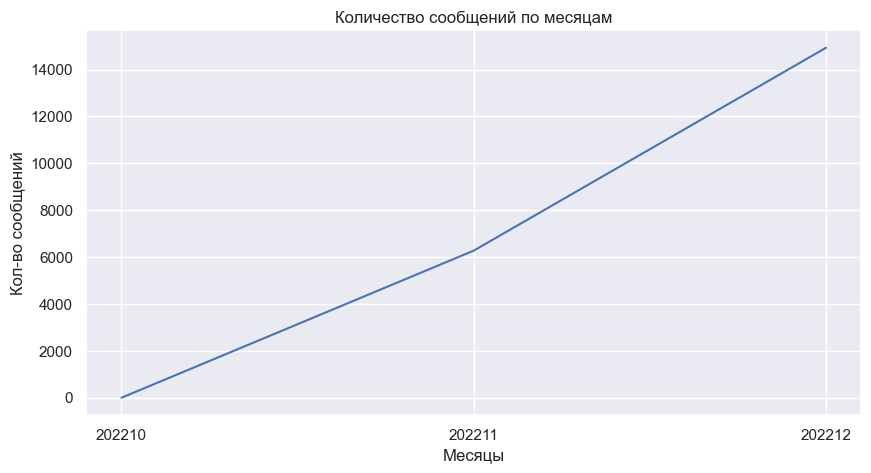

In [28]:
# Сделаем сводную таблицу по месяцам и построим по ней график
data_by_month = df.groupby('message_month')['type'].count().reset_index().rename(columns ={'type':'qty_message'})
display(data_by_month)
data_by_month.info()
sns.lineplot(data = data_by_month, x='message_month', y='qty_message')
plt.title('Количество сообщений по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во сообщений')

Данные представлены за ноябрь - декабрь 2022 года. Посмотрим более детально

Text(0, 0.5, 'Кол-во сообщений')

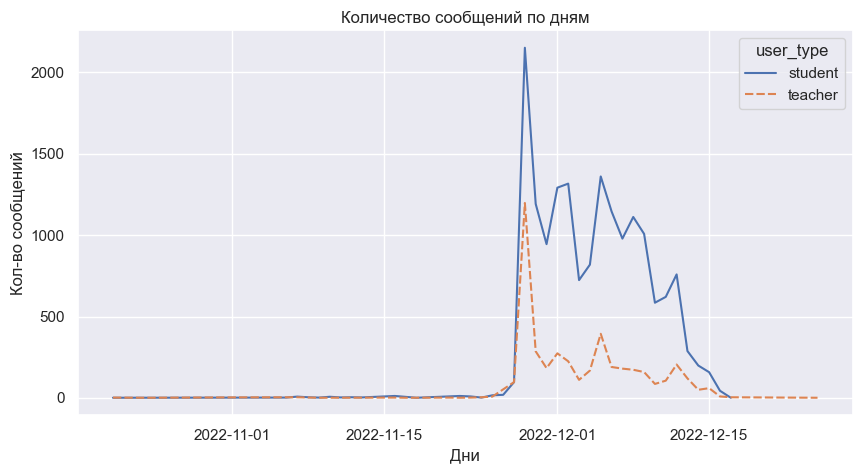

In [29]:
#cltkftv сводную таблицу по дням и построим по ней график
data_by_day = df.pivot_table(index = 'message_day', columns = 'user_type',values = 'type', aggfunc = 'count')
sns.lineplot(data = data_by_day)
plt.title('Количество сообщений по дням')
plt.xlabel('Дни')
plt.ylabel('Кол-во сообщений')

Наблюдается резкий всплеск активности первого декабря и такое же резкое падение 15ого декабря у студентов и преподавателей

## Даты страрта трэдов
Посмотрим на даты старта трэдов. Насколько они корелируютс с началом активности студентов.

Text(0, 0.5, 'Кол-во трэдов')

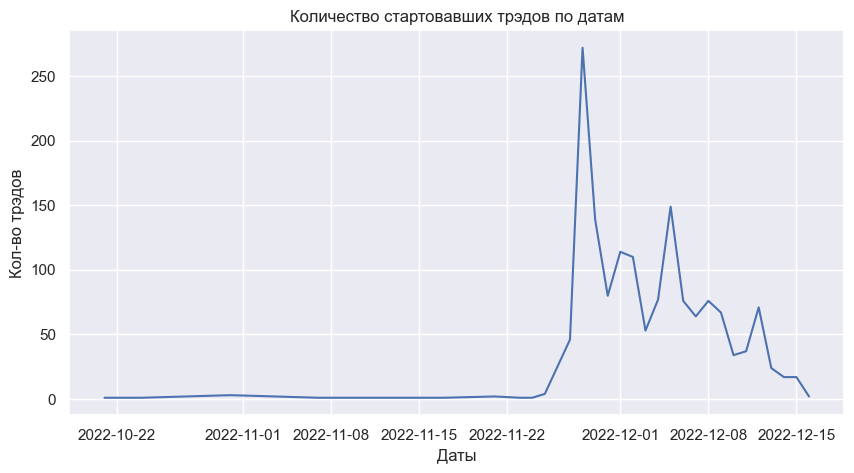

In [30]:
# Выделим день старта трэда
df['tread_day'] = df['thread_ts'].dt.date
# выделим время старта трэда
df['tread_time'] = df['thread_ts'].dt.time
# Сгрупируем дату и время трэдов
tred_data = df.pivot_table(index = ['tread_day', 'tread_time']).reset_index()
# Посчитаем сколько трэдов стартовало за каждый день
tred_data1= tred_data.groupby('tread_day')['tread_time'].count()
sns.lineplot(data = tred_data1)
plt.title('Количество стартовавших трэдов по датам')
plt.xlabel('Даты')
plt.ylabel('Кол-во трэдов')

<h4>Вывод: <a class="tocSkip"> </h4>
    Активность студентов напрямую корелирует с началом трэдов. Это может свидетельствовать о начале учебы у данных групп 1 ого декабря 2022 года. Так как трэды открываются именно тогда. И всплеск активности студентов соответственно тогда же. 

## Активность в трэдах

In [31]:
# посчитаем разницу в минутах между сообщением и началом трэда
df['time_diff'] = (df['ts'] - df['thread_ts']) / np.timedelta64 ( 1 , 'm')

In [32]:
# посчитаем количество сообщений в каждом трэде минимальное, максимальное и среднее время ответа
df1 = df.loc[df['time_diff'] != 0]
tread_activity = (
    df1.groupby('thread_ts').
    agg({'time_diff':['count' , 'min', 'max']}).
    droplevel(0, axis=1).
    reset_index().
    sort_values(by = ['count'], ascending=False).
    rename(columns= {'thread_ts': 'трэды', 'count': 'Кол-во сообщений', 'min': 'Время до первого сообщения','max': 'Время до последнего сообщения'})
)
tread_activity

,трэды,Кол-во сообщений,Время до первого сообщения,Время до последнего сообщения
134,2022-11-28 07:00:58,294,0.02,"23,618.32"
122,2022-11-28 07:00:46,261,244.37,"24,574.85"
123,2022-11-28 07:00:47,258,136.58,"24,803.02"
131,2022-11-28 07:00:55,251,0.02,"25,998.70"
121,2022-11-28 07:00:45,241,506.90,"23,203.55"
...,...,...,...,...
1141,2022-12-07 07:34:25,1,43.50,43.50
502,2022-11-30 11:48:12,1,13.63,13.63
504,2022-11-30 12:10:12,1,"1,349.38","1,349.38"
1135,2022-12-07 06:45:29,1,263.78,263.78


In [33]:
tread_activity.describe()

,Кол-во сообщений,Время до первого сообщения,Время до последнего сообщения
count,"1,540.00","1,540.00","1,540.00"
mean,10.34,989.75,"3,395.32"
std,26.24,"3,120.93","6,543.82"
min,1.00,0.02,0.07
25%,2.00,8.67,106.88
50%,3.00,74.69,835.17
75%,8.00,678.50,"3,027.52"
max,294.00,"61,762.73","62,862.67"


Text(0, 0.5, 'Кол-во трэдов')

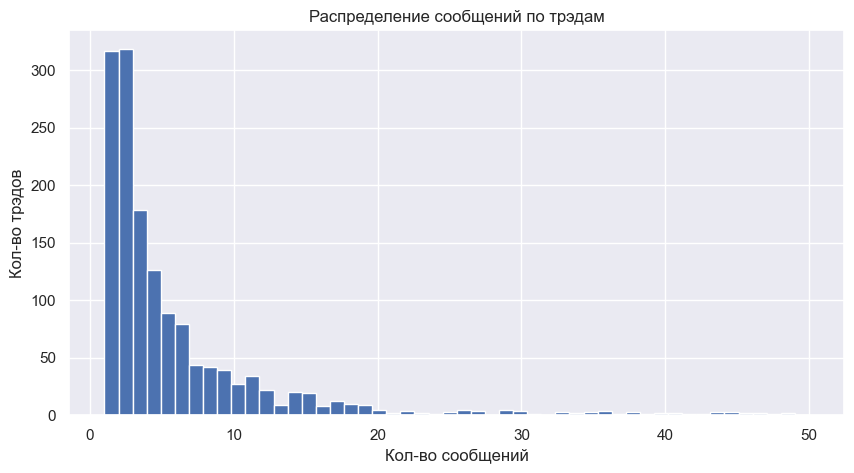

In [34]:
 # построим график распределения сообщений по трэдам
tread_activity.hist('Кол-во сообщений', bins=50, range=(1,50))
plt.title('Распределение сообщений по трэдам')
plt.xlabel('Кол-во сообщений')
plt.ylabel('Кол-во трэдов')

Text(0, 0.5, 'Кол-во трэдов')

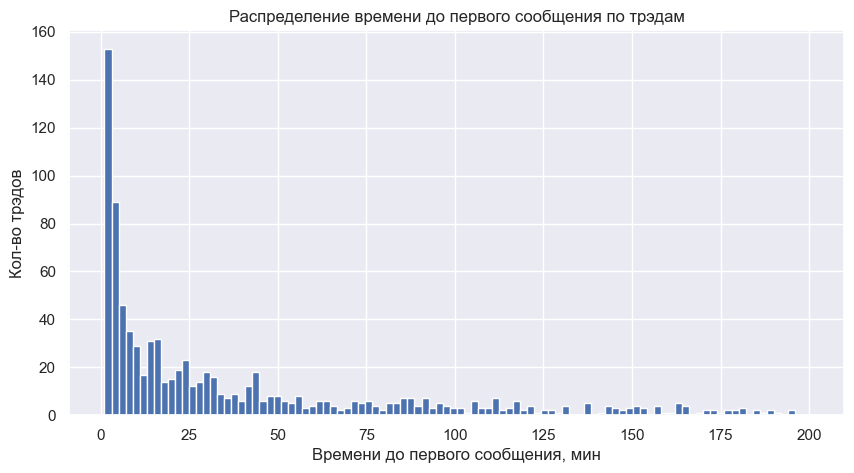

In [35]:
 # построим график распределения времени до первого сообщения  по трэдам
tread_activity.hist('Время до первого сообщения', bins=100, range=(1,200))
plt.title('Распределение времени до первого сообщения по трэдам')
plt.xlabel('Времени до первого сообщения, мин')
plt.ylabel('Кол-во трэдов')

Text(0, 0.5, 'Кол-во трэдов')

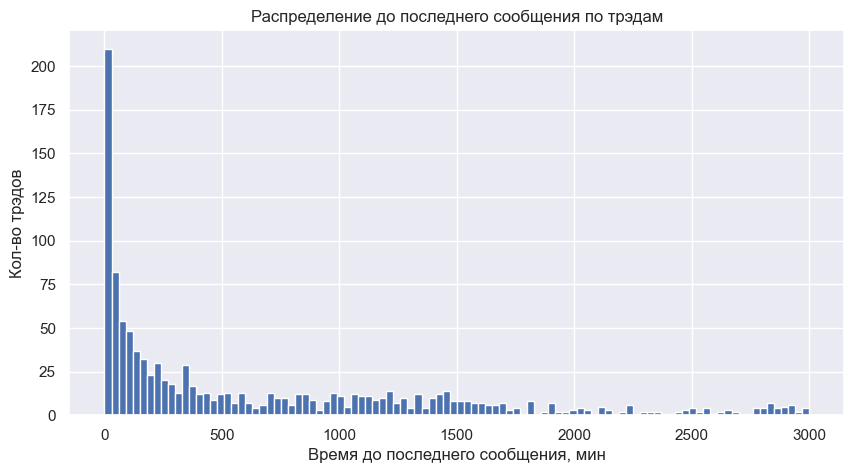

In [36]:
 # построим график распределения времени до последнего сообщения  по трэдам
tread_activity.hist('Время до последнего сообщения', bins=100, range=(1,3000))
plt.title('Распределение до последнего сообщения по трэдам')
plt.xlabel('Время до последнего сообщения, мин')
plt.ylabel('Кол-во трэдов')

<h4>Вывод: <a class="tocSkip"> </h4>

    Всего в выгрузке 1540 трэдов. Большая часть из них состоит из одного - двух сообщений, по 300 штук. Медианное количество сообщений в трэдах - 3. Таких 150шт. Первая квартиль - 2 сообщения. Третья квартиль - 8 сообщений.  
    Минимальное время до первого сообщения менее 1ой минуты. Таких трэдов около 140. Медианное время до первого сообщения 75 мин. 1я квартиль - 9минут 3я квартиль - 679минут.  
    Минимальное время до последнего сообщения так же менее 1ой минуты. Таких трэдов более 50ти. В них всего одно сообщение. Медианное время до последнего сообщения 835 мин. 1я квартиль - 107 минут 3я квартиль - 3000 минут

## Высоконагруженные трэды
Рассмотрим отдельно "Высоконагруженные" трэды. Будем считать таковыми, трэды с количеством сообщений более 50и.

In [37]:
# Выделим высоконагруженные трэды ... более 50 сообщений
high_perfomance_tread = tread_activity.loc[tread_activity['Кол-во сообщений'] > 50]
high_perfomance_tread

,трэды,Кол-во сообщений,Время до первого сообщения,Время до последнего сообщения
134,2022-11-28 07:00:58,294,0.02,"23,618.32"
122,2022-11-28 07:00:46,261,244.37,"24,574.85"
123,2022-11-28 07:00:47,258,136.58,"24,803.02"
131,2022-11-28 07:00:55,251,0.02,"25,998.70"
121,2022-11-28 07:00:45,241,506.90,"23,203.55"
...,...,...,...,...
143,2022-11-28 07:01:07,55,662.77,"19,273.68"
153,2022-11-28 07:01:17,54,"1,745.52","19,359.52"
31,2022-11-27 15:58:50,54,"8,802.25","23,996.07"
968,2022-12-05 09:00:32,53,"4,471.48","13,384.40"


In [38]:
high_perfomance_tread.describe()

,Кол-во сообщений,Время до первого сообщения,Время до последнего сообщения
count,64.00,64.00,64.00
mean,115.23,"1,597.85","21,276.62"
std,61.87,"2,150.91","7,602.44"
min,53.00,0.02,338.82
25%,72.75,243.65,"19,968.38"
50%,94.00,706.15,"22,900.49"
75%,127.25,"2,220.55","24,452.62"
max,294.00,"10,012.02","53,955.80"


Text(0, 0.5, 'Кол-во трэдов')

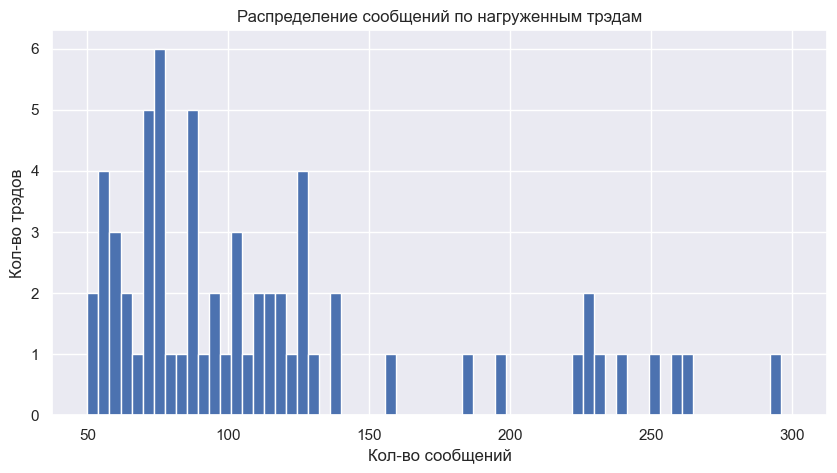

In [39]:
# построим график распределения количества сообщений по нагруженым трэдам
high_perfomance_tread.hist('Кол-во сообщений', bins=64, range=(50,300))
plt.title('Распределение сообщений по нагруженным трэдам')
plt.xlabel('Кол-во сообщений')
plt.ylabel('Кол-во трэдов')

Text(0, 0.5, 'Кол-во трэдов')

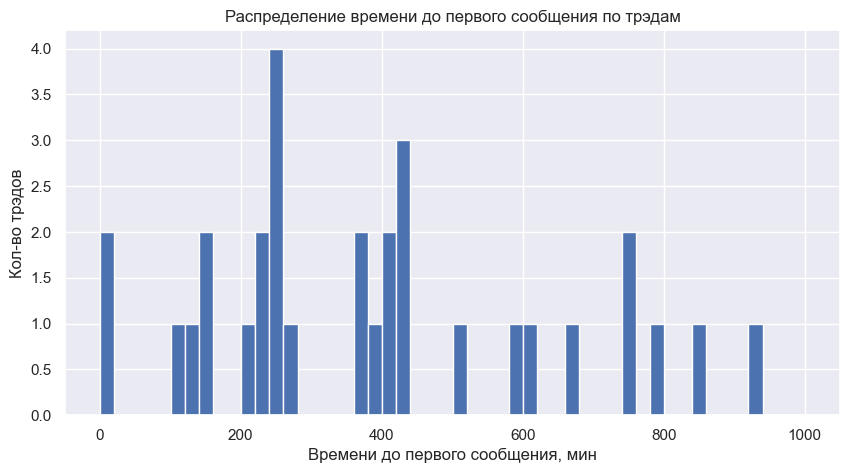

In [40]:
 # построим график распределения времени до первого сообщения  по нагруженным трэдам
high_perfomance_tread.hist('Время до первого сообщения', bins=50, range=(1,1000))
plt.title('Распределение времени до первого сообщения по трэдам')
plt.xlabel('Времени до первого сообщения, мин')
plt.ylabel('Кол-во трэдов')

Text(0, 0.5, 'Кол-во трэдов')

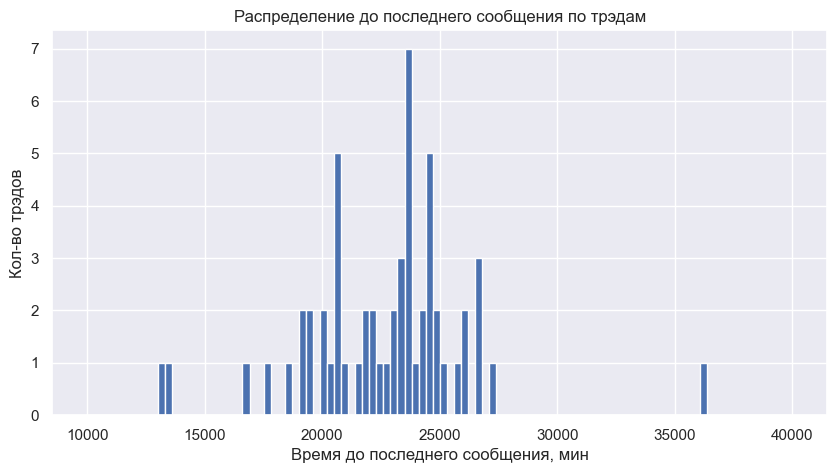

In [41]:
 # построим график распределения времени до последнего сообщения  по нагруженным трэдам
high_perfomance_tread.hist('Время до последнего сообщения', bins=100, range=(10000,40000))
plt.title('Распределение до последнего сообщения по трэдам')
plt.xlabel('Время до последнего сообщения, мин')
plt.ylabel('Кол-во трэдов')

<h4>Вывод: <a class="tocSkip"> </h4>
Выделили нагруженные трэды, с количеством сообщений более 50и. Таких получилось 64 штуки. Но только в двух из них первое сообщение появилось в течение первого часа. В основном в таких трэдах первые сообщения появляются в течение первых суток. "Замолкают" же такие трэды в основном через 17 дней. 

## К каким каналам относятся высоконагруженные трэды

Text(92.109375, 0.5, 'Название когорт')

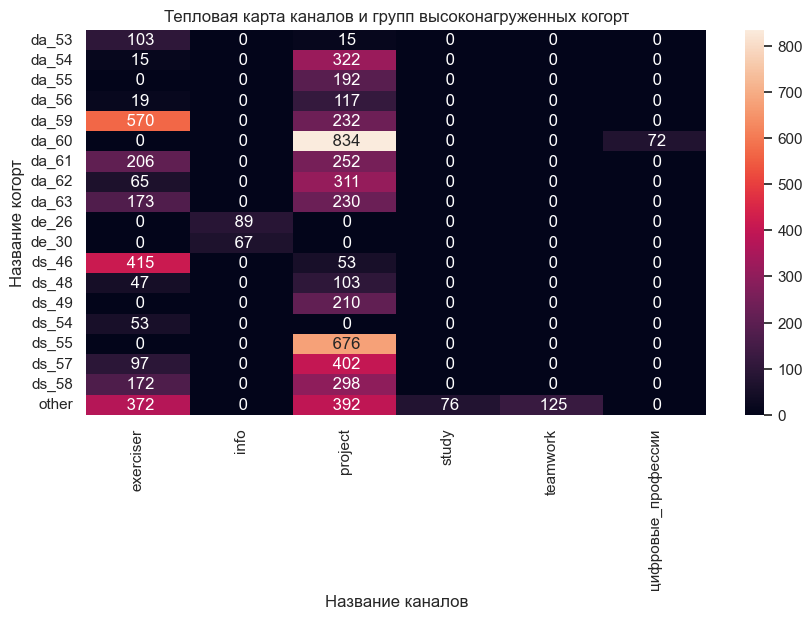

In [42]:
# Сделаем сводную количества сообщений в когортах и разных каналах
high_perfomance_tread['трэды'] = pd.to_datetime(high_perfomance_tread['трэды'], unit='s')
df2 = df1.merge(high_perfomance_tread, how='inner', left_on='thread_ts', right_on='трэды')
high_perfomance_channel = df2.pivot_table(index='chorot_name' , columns = 'channel_type', values = 'type', aggfunc = 'count').fillna(0).astype('int')
fig_2 = sns.heatmap(high_perfomance_channel,  annot= True,  fmt=" d")
fig_2.set_title('Тепловая карта каналов и групп высоконагруженных когорт')
fig_2.set_xlabel('Название каналов')
fig_2.set_ylabel('Название когорт')

<h4>Вывод: <a class="tocSkip"> </h4>
Из тепловой карты становится видно, что самые нагруженные каналы это "exerciser" и "project". И самые активные профессии это da и ds. Самая активная группа da_59 (570 сообщений в exerciser и 232 в project), на втором месте ds_55 (676 сообщений в project). Необходимо внимательнее посмотртреть на группы в которых в одном канале высокая активность, в другом низкая. Например ds_55

## Распределение активности по дням недели

,День недели,user_type,Кол-во сообщений
0,friday,student,2390
1,friday,teacher,403
2,monday,student,4280
3,monday,teacher,1807
4,saturday,student,1333
5,saturday,teacher,201
6,sunday,student,1542
7,sunday,teacher,372
8,thursday,student,2571
9,thursday,teacher,512


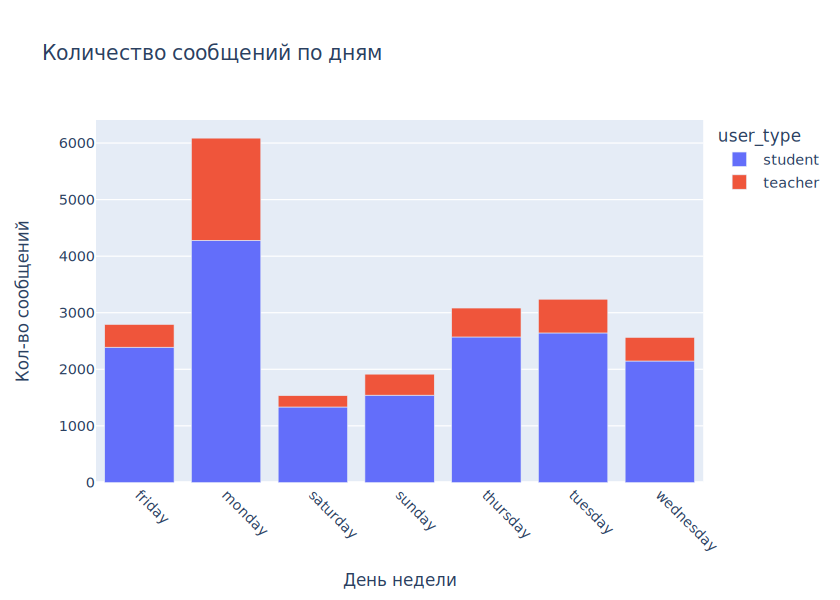

In [43]:
# Сделаем сводную распределения сообщений по дням недели
message_by_day = df.groupby(['message_weekday', 'user_type'])['type'].count().reset_index().rename(columns= {'message_weekday': 'День недели', 'type': 'Кол-во сообщений'})
display(message_by_day)
fig_1 = px.bar(message_by_day, x='День недели', y='Кол-во сообщений', color="user_type", title='Количество сообщений по дням')
fig_1.update_xaxes(tickangle=45)
fig_1.update_layout(xaxis_title="День недели", yaxis_title="Кол-во сообщений")
fig_1.show() 

<h4>Вывод: <a class="tocSkip"> </h4>
    Подсчет количества сообщений по дням привел к следующим результатам. Наибольшая активность, как преподавателей, так и студентов наблюдается в Понедельник. Более 4к сообщений от студентов и более 1,5к сообщений от преподавателей. Самая низкая активность в Субботу и Воскресенье, по 1.3к сообщений от студентов и около 300 у преподпвателей. 
    По остальным дням активность преподавателей распределяется равномерно. 

## Распределение активности по времени суток

,Время суток,user_type,Кол-во сообщений
0,вечер,student,3138
1,вечер,teacher,463
2,день_до_обеда,student,3103
3,день_до_обеда,teacher,785
4,день_после_обеда,student,5731
5,день_после_обеда,teacher,1329
6,ночь,student,1225
7,ночь,teacher,142
8,утро,student,3707
9,утро,teacher,1591


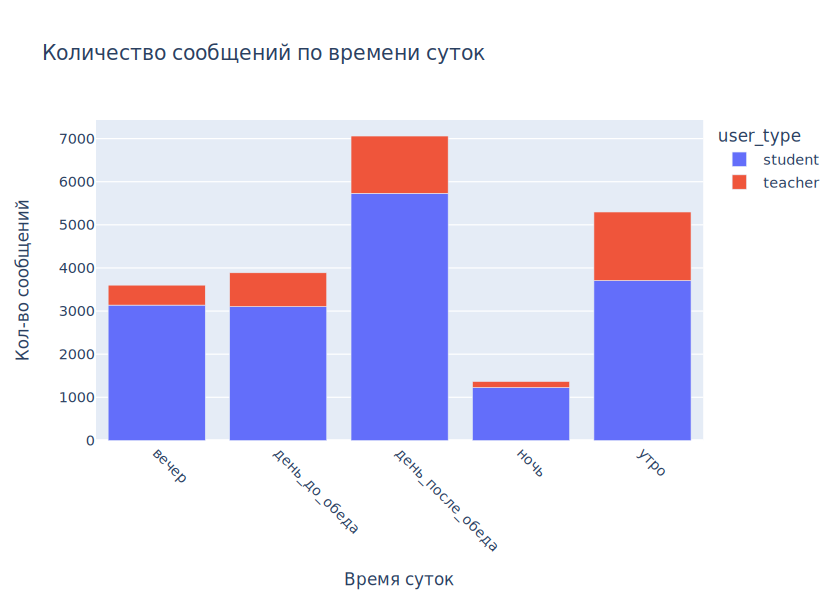

In [44]:
# Сделаем сводную распределения по времени суток
message_by_time = df.groupby(['time_category', 'user_type'])['type'].count().reset_index().rename(columns= {'time_category': 'Время суток', 'type': 'Кол-во сообщений'})
display(message_by_time)
fig_1 = px.bar(message_by_time, x='Время суток', y='Кол-во сообщений', color="user_type", title='Количество сообщений по времени суток')
fig_1.update_xaxes(tickangle=45)
fig_1.update_layout(xaxis_title="Время суток", yaxis_title="Кол-во сообщений")
fig_1.show() 

<h4>Вывод: <a class="tocSkip"> </h4>
    Подсчет количества сообщений по времени суток выявил, что основная активность у преподавателей и студентов утром и днем после обеда.

## Распредеделение активности по дням недели и по суткам 

Text(92.10937499999999, 0.5, 'Время суток')

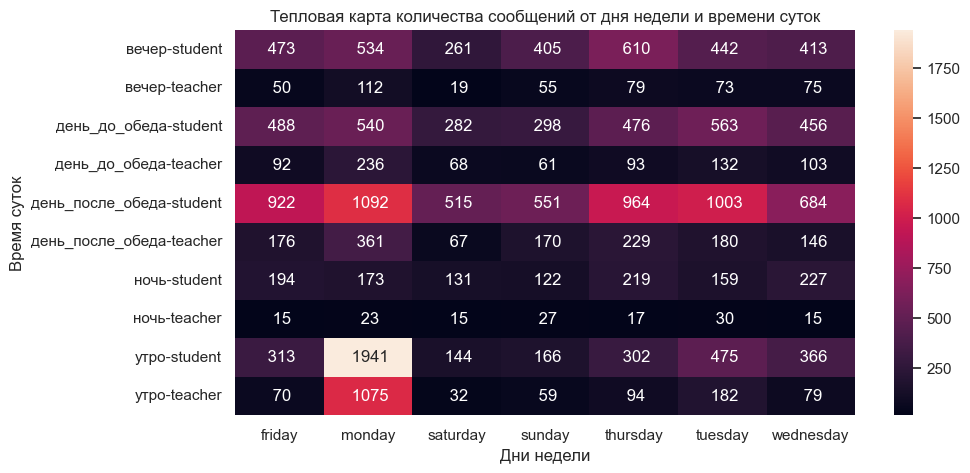

In [45]:
# Сделаем сводную по дням недени и времени суток
message_by_day_time = df.pivot_table(index = ['time_category', 'user_type'], columns = 'message_weekday', values = 'type', aggfunc= 'count').fillna(0).astype('int')
fig_3 = sns.heatmap(message_by_day_time,  annot= True,  fmt=" d")
fig_3.set_title('Тепловая карта количества сообщений от дня недели и времени суток')
fig_3.set_xlabel('Дни недели')
fig_3.set_ylabel('Время суток')

Подсчет количества сообщений в зависимости от дня недели и суток привел к следущим результатам:  
  * Понедельник утро - максимальная активность студентов и преподавателей.
  * Понедельник после обеда - высокая активность студентов. Активность преподавателей средняя.
  * Любой другой день после обеда - Высокая активность у студентов, низкая у преподавателей.
  * В остальное время активность у студентов и преподавателей - низкая.
  * Суббота и Воскресенье - низкая активность весь день.

## Распредеделение активности по дням недели и по суткам у "Активных" когорт

In [46]:
# выделим активные когорты (более 500 сообщений)
high_activity_chorot = df.groupby('chorot_name')['type'].count().reset_index().sort_values(by = 'type', ascending=False)
high_activity_chorot = high_activity_chorot.loc[(high_activity_chorot['chorot_name'] != 'other')&(high_activity_chorot['type'] > 500)]
high_activity_chorot

,chorot_name,type
7,da_59,2132
8,da_60,1269
9,da_61,1157
49,ds_55,1096
50,ds_57,1082
51,ds_58,1028
11,da_63,845
10,da_62,706
42,ds_46,651
5,da_56,636


Text(92.10937499999999, 0.5, 'Время суток')

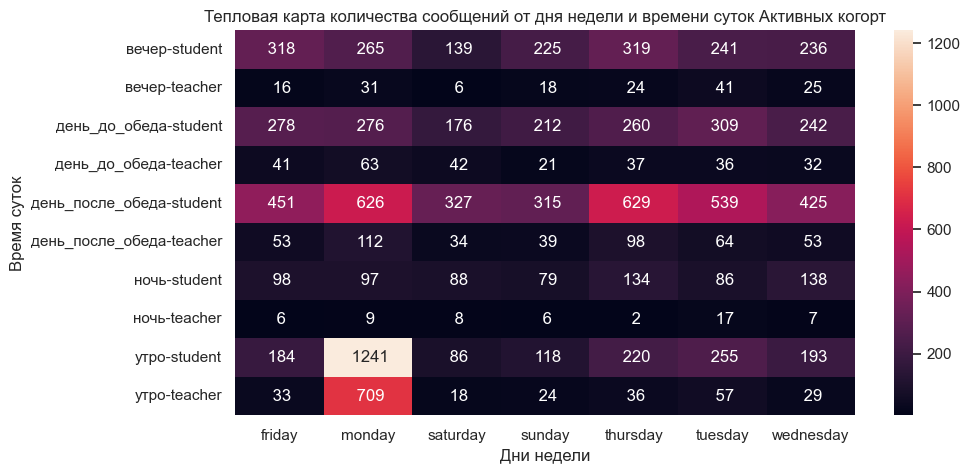

In [47]:
df3 = df.merge(high_activity_chorot, how='inner', left_on='chorot_name', right_on='chorot_name')
message_by_day_time_1 = df3.pivot_table(index = ['time_category', 'user_type'], columns = 'message_weekday', values = 'type_x', aggfunc= 'count').fillna(0).astype('int')
fig_3 = sns.heatmap(message_by_day_time_1,  annot= True,  fmt=" d")
fig_3.set_title('Тепловая карта количества сообщений от дня недели и времени суток Активных когорт')
fig_3.set_xlabel('Дни недели')
fig_3.set_ylabel('Время суток')

Принципиально ничего не поменялось. Тепловая карта активных груп повторяет общую картину.

## Проверка активности студентов

,user,message_qnt,reactions_qty
1080,U041DK9LAQ0,7,0
810,U03QVC4AHTL,1,0
809,U03QVC47A8J,1,0
807,U03QVA7LAKV,1,0
806,U03QTD5E09X,6,0
...,...,...,...
2252,USWN6S8V6,215,68
1174,U042JHYBWTV,25,68
997,U040FP9JRNF,211,87
2256,UU59EH1B8,196,92


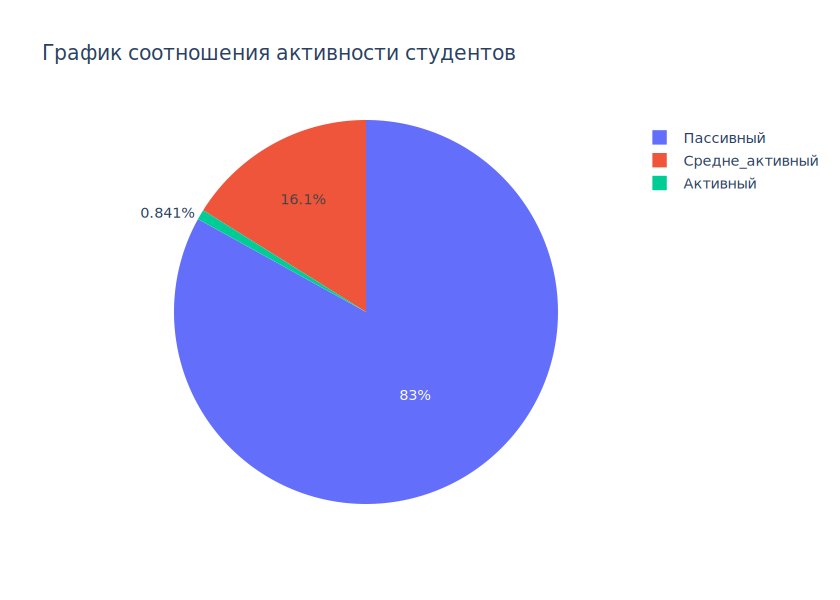

In [48]:
# Посчитаем количество сообщений и реакций у студентов
df4 = df.query('user_type == "student"').groupby('user').agg({'type':'count' , 'reactions_qty':'sum'}).reset_index().rename(columns={'type':'message_qnt'})
display(df4.sort_values(by = 'reactions_qty'))
# введем категории активности студентов
df4['student_activity'] = 'Средне_активный'
df4.loc[(df4['message_qnt'] > 100)|(df4['reactions_qty'] > 50), 'student_activity']='Активный'
df4.loc[(df4['message_qnt'] < 10)&(df4['reactions_qty'] < 10), 'student_activity']='Пассивный'
layout = go.Layout(title='График соотношения активности студентов')
fig = go.Figure(data = [go.Pie(labels = df4['student_activity'])], layout = layout)
fig

<h4>Вывод: <a class="tocSkip"> </h4>
    Выявилась еще одна неожиданная особенность. 83% всех студентов пассивно ведут себя в чатах (то  есть, за все время исследования написали менее 10 сообщений и при этом поставили менее 10 реакций) А активных студентов, которые более 100 сообщений или поставили более 50 реакций, менее 1%.  

## Проверка активности преподавателей.

,user,message_qnt,reactions_qty
94,U03M8M1EV41,9,0
136,U042J58HV19,1,0
76,U03F5E7V3V0,13,0
137,U042J5DTAR1,6,0
138,U042J8F464A,1,0
...,...,...,...
121,U03V7HU6PM2,20,215
214,UUMQAGFHC,60,231
64,U03A3EWK561,75,257
47,U031KRDA3FW,96,321


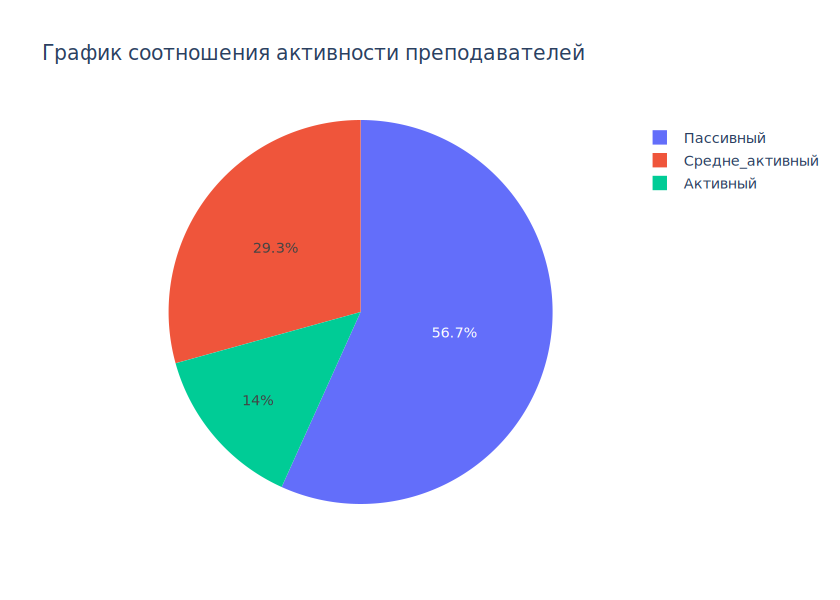

In [49]:
# Проанализируем преподавателей так же как и со студентов. 
df5 = df.query('user_type == "teacher"').groupby('user').agg({'type':'count' , 'reactions_qty':'sum'}).reset_index().rename(columns={'type':'message_qnt'})
display(df5.sort_values(by = 'reactions_qty'))
df5['student_activity'] = 'Средне_активный'
df5.loc[(df5['message_qnt'] > 100)|(df5['reactions_qty'] > 50), 'student_activity']='Активный'
df5.loc[(df5['message_qnt'] < 10)&(df5['reactions_qty'] < 10), 'student_activity']='Пассивный'
layout = go.Layout(title='График соотношения активности преподавателей')
fig = go.Figure(data = [go.Pie(labels = df5['student_activity'])], layout = layout)
fig

<h4>Вывод: <a class="tocSkip"> </h4>
    У преподавателей ситуация выглядит лучше, чем у студентов. Половина преподавателей - активны в чатах. Но тем не менее 56% преподователей написали менее 10и сообщений.

## Распределение сообщений по количеству слов

,qty_words,qty_message
count,458.00,458.00
mean,134.46,46.32
std,109.80,115.95
min,0.00,1.00
25%,57.00,1.00
50%,115.00,4.00
75%,183.75,25.75
max,989.00,724.00


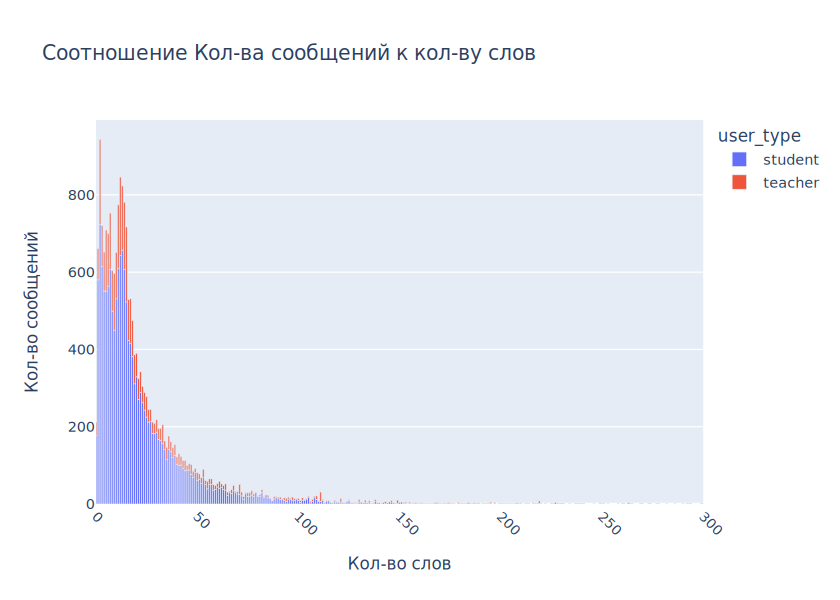

In [50]:
# посчитаем длину сообщений
qty_words = df.groupby(['user_type','text_words'])['type'].count().reset_index().rename(columns={'text_words':'qty_words','type':'qty_message'})
display(qty_words.describe())
fig_3 = px.bar(qty_words, x='qty_words', y='qty_message', color="user_type", title='Соотношение Кол-ва сообщений к кол-ву слов')
fig_3.update_xaxes(tickangle=45)
fig_3.update_xaxes(range=[0 , 300])
fig_3.update_layout(xaxis_title="Кол-во слов", yaxis_title="Кол-во сообщений")
fig_3.show() 


    И студенты и преподаватели пишут в основном короткие сообщения. От 2ух до 10 слов. Таких сообщений по 600 шт у студентов и по 150шт у преподавателей. Выведем более наглядный график.

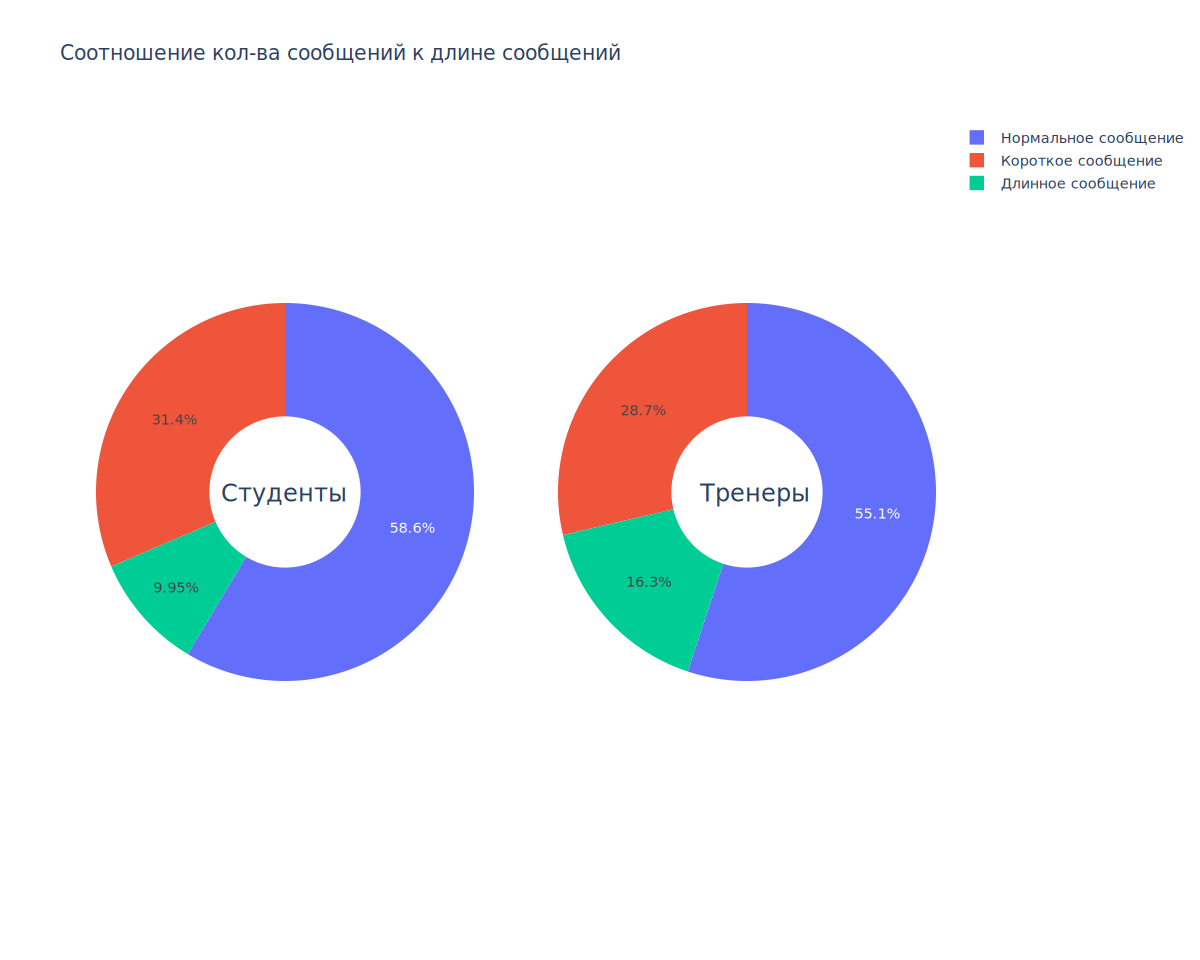

In [51]:
# Заведем категории до 10 слов - короткое сообщение, 10 - 50 слов нормальное сообщение, более 50 длинное
df['message_category'] = 'Нормальное сообщение'
df.loc[(df['text_words'] > 50), 'message_category']='Длинное сообщение'
df.loc[(df['text_words'] < 10), 'message_category']='Короткое сообщение'
df_5 = df.query('user_type == "student"')
df_6 = df.query('user_type == "teacher"')
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
#layout = go.Layout(title='График соотношения длины сообщений')
fig.add_trace(go.Pie(labels = df_5['message_category']), 1, 1)
fig.add_trace(go.Pie(labels = df_6['message_category']), 1, 2)
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(height=800, width=1000, 
                  title_text="Соотношение кол-ва сообщений к длине сообщений",
                  annotations=[dict(text='Студенты', x=0.15, y=0.5, font_size=20, showarrow=False), dict(text='Тренеры', x=0.85, y=0.5, font_size=20, showarrow=False)])

fig.show()

<h4>Вывод: <a class="tocSkip"> </h4> 
    По данным графикам становится видно что и студенты и преподаватели в половине случаев пишут средней длины сообщения (от 10 до 50 слов) или короткие - менее 10 слов (менее 30% случаев). Длинные сообщения преподаватели пишуть чаще в 16% случаев против 10% случаев у студентов.

## Анализ особо длинных сообщений

In [52]:
# Выделим длинные сообщения (более 200 слов)
df_7 =  df.query('text_words > 200')

### Кто пишет

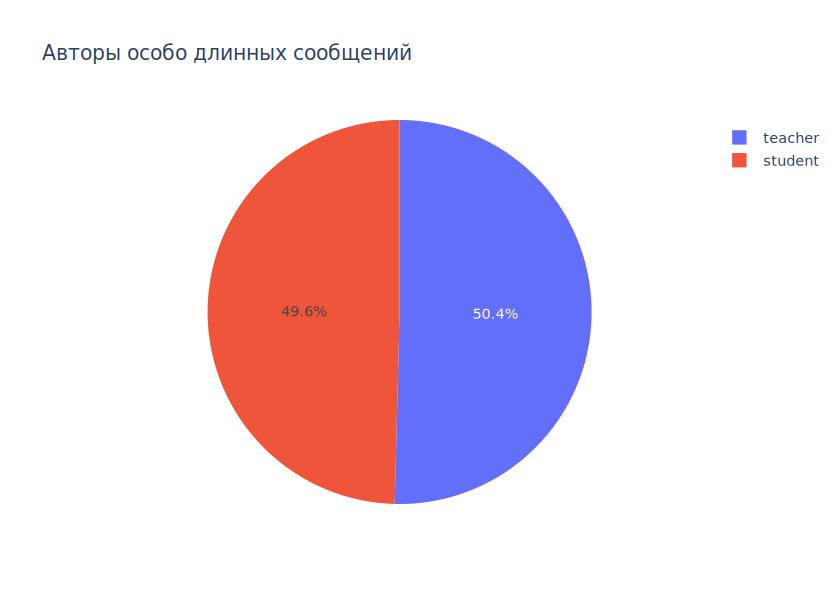

In [53]:
layout = go.Layout(title='Авторы особо длинных сообщений')
fig = go.Figure(data = [go.Pie(labels = df_7['user_type'])], layout = layout)
fig

Авторы длинных сообщений поделились пополам. В половине случаев студенты, в половине - преподаватели

### Когда пишут 

Text(92.10937499999999, 0.5, 'Время суток')

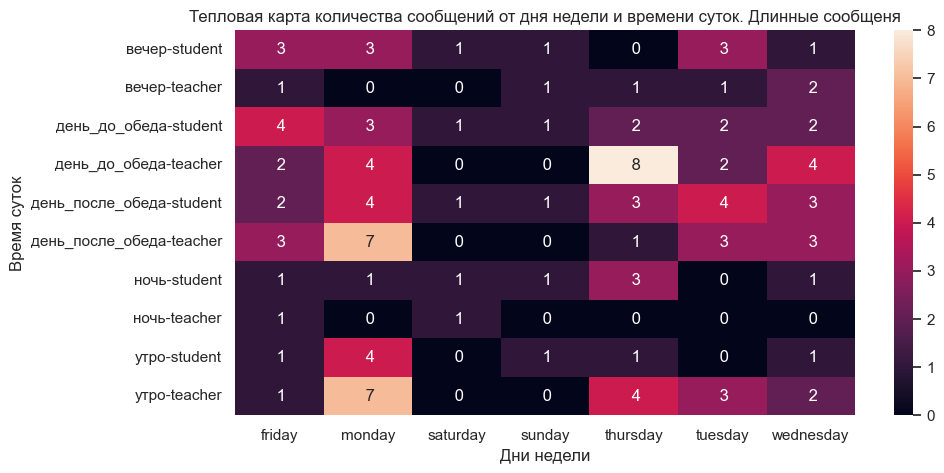

In [54]:
message_by_day_time_2 = df_7.pivot_table(index = ['time_category', 'user_type'], columns = 'message_weekday', values = 'type', aggfunc= 'count').fillna(0).astype('int')
fig_3 = sns.heatmap(message_by_day_time_2,  annot= True,  fmt=" d")
fig_3.set_title('Тепловая карта количества сообщений от дня недели и времени суток. Длинные сообщеня')
fig_3.set_xlabel('Дни недели')
fig_3.set_ylabel('Время суток')

Традиционно, авторы длинных сообщений активны в понедельник весь день кроме вечера и ночи. Преподаватели активны еще в четверг. 

### Популярны ли данные сообщения

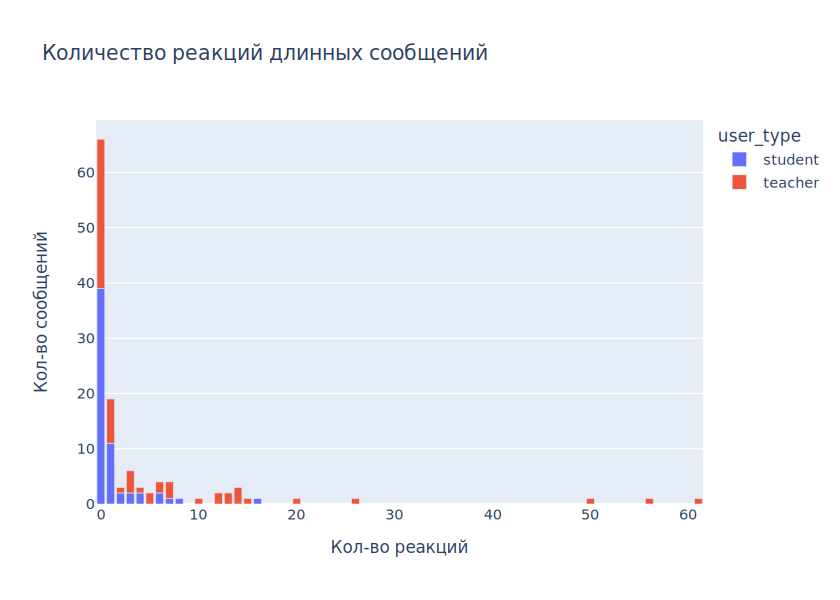

In [55]:
# построим сводную и график количества реакций на длинные сообщения
reactions_long_mess = df_7.groupby(['user_type', 'reactions_qty'])['type'].count().fillna(0).reset_index()
reactions_long_mess
fig_1 = px.bar(reactions_long_mess, x='reactions_qty', y='type', color="user_type", title='Количество реакций длинных сообщений')
fig_1.update_layout(xaxis_title="Кол-во реакций", yaxis_title="Кол-во сообщений")
fig_1.show() 

НЕТ. Данные сообщения не собирают много реакций. в большинстве случаев пользователи на них вообще не реагируют. На отдельные сообщения преподавателей есть достаточно бурная реакция. 

<h4>Вывод: <a class="tocSkip"> </h4> 
    Анализ особо длинных сообщений показал, Что пишут их как преподаватели, иак и студенты. В пропорции 50/50. На сообщения преподавателей реакций больше. И пишутся они примерно в то же время как и остальные сообщения(Воскресенье - Понедельник)

# Общий вывод

В качестве объекта исследования была получена выгрузка данных из месенджера Slak. В таблице 26533 записей, и 14 столбцов. 7 столбцов - текстовые, 4 - с датами и временем, 2-целочисленные, 1 - булевый. 7 столбцов не имеют пропусков. Остальные семь имеют пропуски от 10% до 91%. Больше всего пропусков в столбцах с реакциями и временем ответа 84 и 91 процент.

Была выполнена предобработка данных. Были выделенны данные: названия групп, типы каналов, года, месяцы, дни недель сообщений. Введены категории определяющие время суток,  длину сообщения. Пользователей разделили на студентов и преподавателей. Удалены служебные сообщения.

В изучаемом датафрейме представлены данные о сообщениях с начала ноября 2022 года по конец декабря 2022 года. Большинство трэдов стартуют 1 декабря. Активность в трэдах длится до 15 декабря. Всего в выгрузке 1540 трэдов. Большая часть из них состоит из одного - двух сообщений, по 300 штук. Медианное количество сообщений в трэдах - 3. Таких 150шт. Первая квартиль - 2 сообщения. Третья квартиль - 8 сообщений.  
Минимальное время до первого сообщения менее 1ой минуты. Таких трэдов около 140. Медианное время до первого сообщения 75 мин. 1я квартиль - 9минут 3я квартиль - 679минут.  
Минимальное время до последнего сообщения так же менее 1ой минуты. Таких трэдов более 50ти. В них всего одно сообщение. Медианное время до последнего сообщения 835 мин. 1я квартиль - 107 минут 3я квартиль - 3000 минут.  
Выделили нагруженные трэды, с количеством сообщений более 50и. Таких получилось 64 штуки. Но только в двух из них первое сообщение появилось в течение первого часа. В основном в таких трэдах первые сообщения появляются в течение первых суток. "Замолкают" же такие трэды в основном через 17 дней.
Нагруженные трэды относятся к каналам "exerciser" и "project". И самые активные профессии это da и ds. Самая активная группа da_59 (570 сообщений в exerciser и 232 в project), на втором месте ds_55 (676 сообщений в project). Необходимо внимательнее посмотртреть на группы в которых в одном канале высокая активность, в другом низкая. Например ds_55.  
Подсчет количества сообщений по дням недели привел к следующим результатам:
 - Понедельник утро - максимальная активность студентов и преподавателей.
 - Понедельник после обеда - высокая активность студентов. Активность преподавателей средняя.
 - Любой другой день после обеда - Высокая активность у студентов, низкая у преподавателей.
 - В остальное время активность у студентов и преподавателей - низкая.
 - Суббота и Воскресенье - низкая активность весь день.  
По остальным дням активность преподавателей распределяется равномерно.  
Выявилась еще одна неожиданная особенность. 83% всех студентов пассивно ведут себя в чатах (то есть, за все время исследования написали менее 10 сообщений и при этом поставили менее 10 реакций) А активных студентов, которые более 100 сообщений или поставили более 50 реакций, менее 1%.  
У преподавателей ситуация выглядит лучше, чем у студентов. Половина преподавателей - активны в чатах. Но тем не менее 56% преподователей написали менее 10и сообщений.  
Анализ особо длинных сообщений не выявил каких либо паттернов. 

# Рекомендации

В связи с тем, что исследование показало отвутствие активности в чатах 50% преподавателей, необходимо провести отделльное исследование какие преподаватели должны быть активными в чате и разработать систему мотивации активности в чатах.   

Такой же подход можно применить к студентам. 80% студентов не активны в чатах. Система мотивации значительно увеличит данный показатель. Например поставь 100 реакций или собери 100 лайков и получи скидку на следующий месяц.

Что касается времени рассылки важных сообщений - Понедельник утро для этого тот самый момент. 